 #### Coded by: Vikranth

In [2]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.io
%matplotlib notebook

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using TensorFlow backend.


(180000, 15)
(86757, 3)
(86757, 15)


<IPython.core.display.Javascript object>


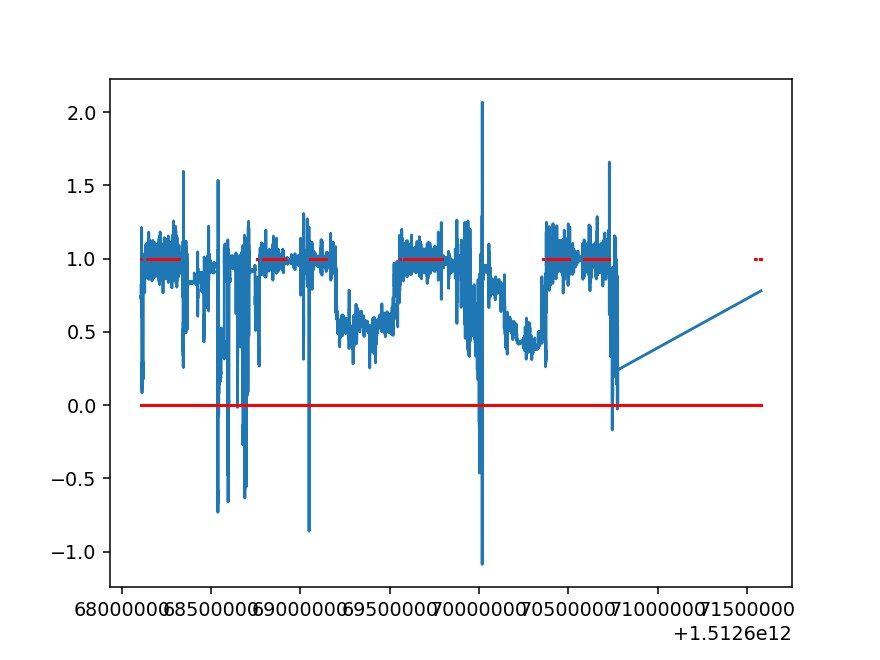

In [53]:
participant_1 = pd.read_pickle('Participant_1.pkl')
#print(participant_1)
labels_1 = np.load('Participant_1_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'r.', ms = 1)
plt.show()

Counter({0.0: 65815, 1.0: 17721, 2.0: 3221})
(65815, 1)
(65815, 15)


<IPython.core.display.Javascript object>


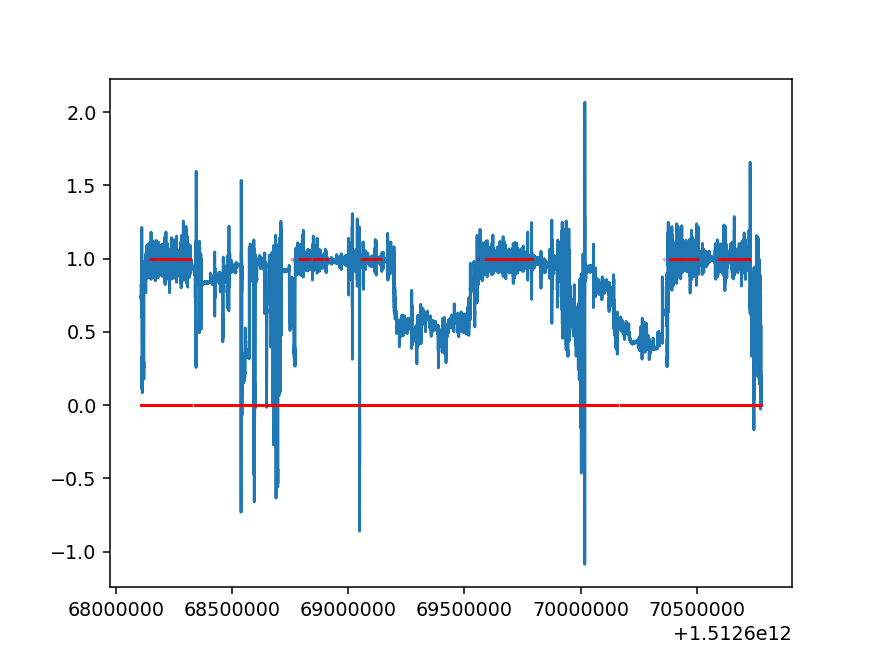

In [54]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
speed_labels = labels_1[np.where(missing_1 == 0),2].reshape((-1,1))

print(speed_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],speed_labels,'r.', ms = 0.1)
plt.show()

In [56]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 25 #Default 10 
stride = 25 #Default 10

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
speed_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    speed_labels_cp[k] = np.sum(speed_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(speed_labels_cp.shape)

(6581, 10, 12)
(6581, 1)


In [57]:
Counter(speed_labels_cp[:,0])

Counter({0.0: 4931,
         1.0: 515,
         2.0: 577,
         3.0: 392,
         4.0: 95,
         5.0: 28,
         6.0: 10,
         7.0: 4,
         8.0: 8,
         9.0: 5,
         10.0: 16})

In [62]:
indices = np.where(np.logical_and(speed_labels_cp > 0, speed_labels_cp < 3 ))[0]
speed_labels_cp[indices,0] = 1
indices = np.where(speed_labels_cp >= 3)[0]
speed_labels_cp[indices,0] = 2

(558,)
[  98  103  104  117  135  143  144  146  155  160  172  173  175  177  180
  182  183  187  188  190  191  192  201  207  208  209  210  214  228  240
  242  245  249  266  272  273  277  278  279  285  288  297  299  300  301
  302  303  307  308  309  328  333  336  339  342  345  347  348  355  359
  371  373  374  375  380  381  398  420  436  437  441  445  447  448  450
  451  452  453  456  461  464  468  469  470  471  472  473  474  476  481
  483  484  486  488  489  490  492  493  497  499  502  505  507  509  511
  512  518  522  524  527  530  531  536 1667 1676 1679 1681 1684 1685 1698
 1699 1703 1722 1723 1724 1725 1727 1730 1736 1744 1747 1749 1751 1752 1753
 1754 1776 1819 1821 1824 1829 1832 1836 1838 1845 1846 1848 1850 1851 1857
 1881 1882 1885 1887 1892 1893 1900 1912 1913 1941 1943 1951 1957 1963 2327
 2343 2358 2359 2360 2361 2362 2363 2378 2379 2380 2381 2382 2383 2384 2385
 2386 2401 2402 2403 2404 2405 2406 2408 2414 2415 2416 2418 2419 2423 2425
 2426

In [63]:
print(Counter(speed_labels_cp[:,0]))
print(np.shape(speed_labels_cp))

Counter({0.0: 4931, 1.0: 1092, 2.0: 558})
(6581, 1)


<IPython.core.display.Javascript object>


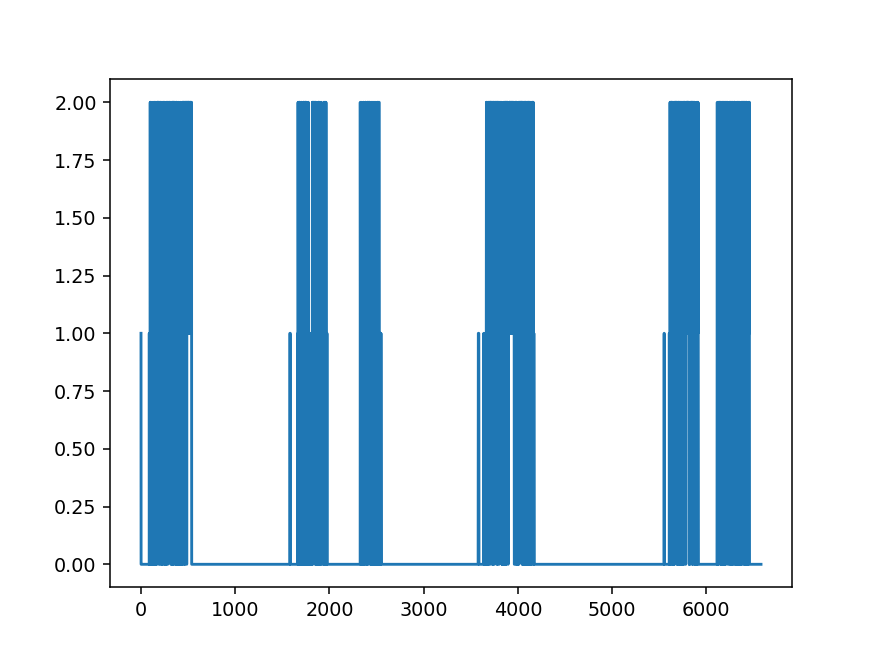

In [79]:
plt.figure()
plt.plot(speed_labels_cp[:,0])
plt.show()

In [66]:
z = 13000
X_train0 = data_slide[:z]
Y_train = speed_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = speed_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))

In [ ]:
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [108]:
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    #_, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))
    
    print (np.shape(X_train))
    print (np.shape(X_train))
    return X_train, X_valid

In [ ]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))
    

In [ ]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)


In [ ]:
p=0.3 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()


In [111]:
epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_test, Y_test))


model training ...
Train on 6500 samples, validate on 81 samples
Epoch 1/20
6500/6500 [==============================] - 6s - loss: 0.7496 - acc: 0.7103 - val_loss: 0.4363 - val_acc: 0.9012
Epoch 2/20
6500/6500 [==============================] - 3s - loss: 0.5742 - acc: 0.7552 - val_loss: 0.2740 - val_acc: 0.9506
Epoch 3/20
6500/6500 [==============================] - 3s - loss: 0.5329 - acc: 0.7672 - val_loss: 0.2103 - val_acc: 0.9753
Epoch 4/20
6500/6500 [==============================] - 3s - loss: 0.5170 - acc: 0.7748 - val_loss: 0.1212 - val_acc: 0.98770.7
Epoch 5/20
6500/6500 [==============================] - 3s - loss: 0.5034 - acc: 0.7825 - val_loss: 0.1355 - val_acc: 0.9877
Epoch 6/20
6500/6500 [==============================] - 3s - loss: 0.4953 - acc: 0.7823 - val_loss: 0.1590 - val_acc: 0.9877
Epoch 7/20
6500/6500 [==============================] - 3s - loss: 0.4773 - acc: 0.7926 - val_loss: 0.1140 - val_acc: 0.9877
Epoch 8/20
6500/6500 [==============================] - 3

In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


calculating confusion matrix ... 
[[78  3]
 [ 0  0]]
the mean f1 score:0.49


C:\Users\Vikranth\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


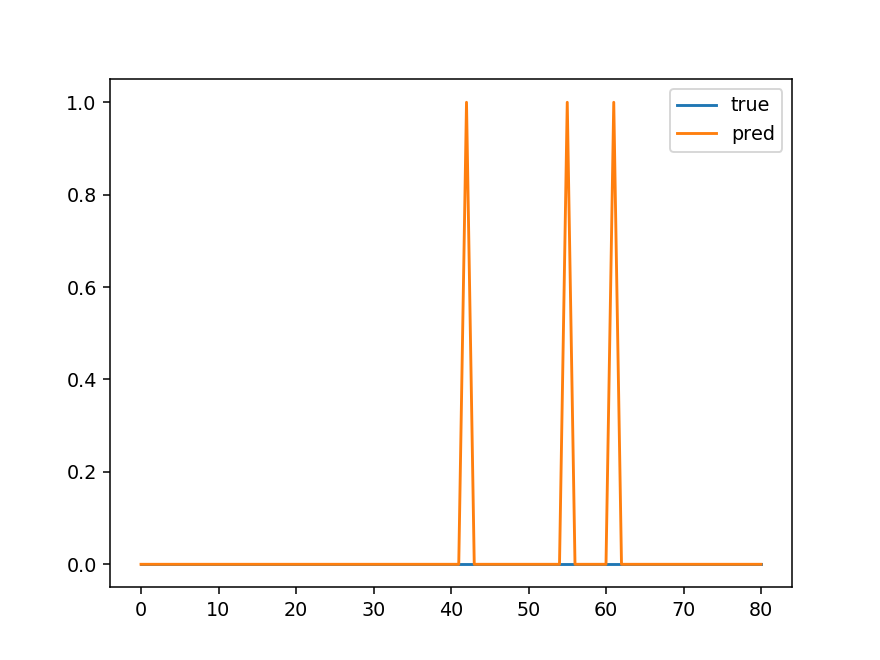

In [113]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [114]:
model.save('LSTM.h5')